2. iv. Can one use regression to associate CREs with gene expression?

    - a. How much of the variance of gene expression can be explained for each gene with this approach?

In [82]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os

DATA_DIR = "data/"
DATA_PROC_DIR = "data-processed/"
ATAC_SEQ_PATH = os.path.join(DATA_DIR, "ImmGenATAC18_AllOCRsInfo.csv")
RNA_SEQ_PATH = os.path.join(DATA_DIR, "mmc2.csv")
#REFFLAT_PATH = os.path.join(DATA_DIR, "refFlat.txt.gz")
PROC_PEAKS_PATH = os.path.join(DATA_PROC_DIR, "peaks_annotated.csv")

# --- 1. Load Data ---
# 1.1 CRE annotations (must include 'peak_id' and 'nearest_gene')
peaks = pd.read_csv(PROC_PEAKS_PATH)
#peaks["peak_id"] = peaks.index  # ensure a unique integer ID

# 1.2 ATAC accessibility (peaks × cellTypes)
atac = pd.read_csv(ATAC_SEQ_PATH, index_col=[0,1,2]).drop(columns=["mm10.60way.phastCons_scores", "_-log10_bestPvalue", "Included.in.systematic.analysis"])
atac = atac.select_dtypes(include=[np.number]).dropna(axis=0, how='any')
#atac = atac.mean(axis=1, numeric_only=True)
#atac.index.names = ["chrom","start","end"]

# 1.3 RNA expression (genes × cellTypes)
rna = pd.read_csv(RNA_SEQ_PATH, index_col=0)
#rna = rna.mean(axis=1, numeric_only=True)

In [83]:
# --- 2. Build gene → CRE mapping ---
# We'll use the 'TSS_GeneName' field to link peaks to their gene.
#gene_to_peaks = peaks.groupby("TSS_GeneName")["id"].apply(list).to_dict()

# 2.1 Explode the gene lists
peaks["gene_list"] = peaks["genes.within.100Kb"].str.split(",")
peaks_exploded = peaks.explode("gene_list").rename(columns={"gene_list":"gene"})
# Drop any empty gene entries
peaks_exploded = peaks_exploded[peaks_exploded["gene"].notna() & (peaks_exploded["gene"]!="")]

# 2.2 Group to get mapping: gene → list of peak_ids
gene_to_peaks = peaks_exploded.groupby("gene")["id"].apply(list).to_dict()

# --- 3. Perform regression ---
def perform_regression(atac_data, rna_data):
    """
    Perform linear regression for each gene based on ATAC data.
    
    Parameters:
    - atac_data: DataFrame with ATAC accessibility data (peaks × cellTypes).
    - rna_data: DataFrame with RNA expression data (genes × cellTypes).
    
    Returns:
    - results: DataFrame with regression results for each gene.
      Contains columns: 'gene', 'R2', 'n_CRes'.
    - peak_means: DataFrame with mean values for RNA and ATAC peaks.
    """
    results = []
    peak_means = []
    model = LinearRegression()

    for gene, peak_ids in gene_to_peaks.items():
        # skip if gene not in RNA or too few CREs
        if gene not in rna_data.index or len(peak_ids) < 2:
            continue

        # Build X: shape (n_cellTypes, n_peaks)
        sub = atac_data.loc[peak_ids]  # DataFrame: rows=CREs, cols=cell types

        # DROP any CRE row with NA
        sub_clean = sub.dropna(axis=0, how="any")
        if sub_clean.shape[0] < 2:
            continue

        X = sub_clean.values.T  # transpose → samples × features

        # Build y: expression vector for this gene across same cellTypes
        y = rna_data.loc[gene].values

        peak_means.append({"RNA Peak Strength": y.mean(), "ATAC Peak Strength": X.mean(axis=0)})

        # Fit and record R^2
        try:
            model.fit(X, y)
            r2 = model.score(X, y) # R^2
            beta = model.coef_  # beta coefficient across cell types
        except Exception as e:
            logging.warning(f"Regression failed for {gene}: {e}")
            continue

        results.append({"gene": gene, 
                        "R2": r2, "beta": beta, 
                        "peaks": peak_ids,
                        "n_CRes": len(peak_ids)})
    
    print(f"Computed R² for {len(results)} genes.")
    return pd.DataFrame(results).set_index("gene"), pd.DataFrame(peak_means)

In [84]:
# Align to only the intersection of cell types
common_cells = atac.columns.intersection(rna.columns)
if len(common_cells) < len(atac.columns) or len(common_cells) < len(rna.columns):
    print(f"Aligning to {len(common_cells)} common cell types "
          f"(was {len(atac.columns)} ATAC, {len(rna.columns)} RNA)")

results, peak_means_raw = perform_regression(atac[common_cells], rna[common_cells])
peak_means = peak_means_raw.explode("ATAC Peak Strength")

Aligning to 85 common cell types (was 90 ATAC, 86 RNA)
Computed R² for 17469 genes.


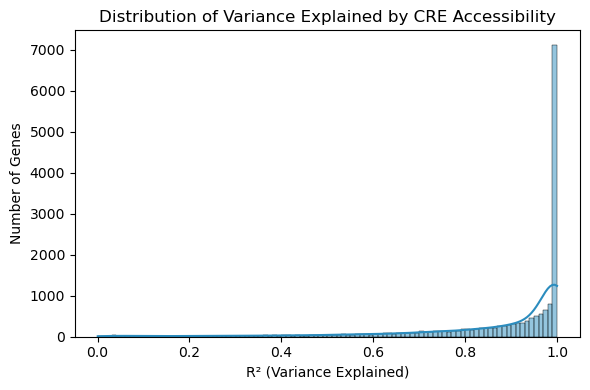

count    17469.000000
mean         0.873958
std          0.198776
min          0.000491
25%          0.830172
50%          0.967230
75%          1.000000
max          1.000000


In [85]:

# --- 5. Plot distribution of R² ---
#sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.histplot(results["R2"], bins=100, kde=True, color="#2b8cbe")
plt.xlabel("R² (Variance Explained)")
plt.ylabel("Number of Genes")
plt.title("Distribution of Variance Explained by CRE Accessibility")
plt.tight_layout()
#plt.savefig("reports/R2_distribution.png", dpi=300)
plt.show()

# Optional: print summary statistics
print(results["R2"].describe().to_string())

In [86]:
results.sort_values("R2", ascending=False, inplace=True)
results.sort_values("n_CRes", ascending=False, inplace=True)
print(f"Top 20 genes by R²:\n{results.head(20)}")

Top 20 genes by R²:
                R2                                               beta  \
gene                                                                    
Foxp1          1.0  [2.1334595222971675, -2.500092717872957, -2.12...   
Frmd4a         1.0  [-0.4020844727967534, 0.4743739889570016, -1.2...   
Sgms1          1.0  [-5.457254772655734, -2.37269351140823, -8.106...   
Nav2           1.0  [0.12035858331687432, -0.6264992022217133, -1....   
Sept9          1.0  [6.86124565908974, -9.148132054633946, -6.4506...   
Arhgef3        1.0  [-3.427893164218396, 9.874004089992383, 2.0941...   
Rgs3           1.0  [6.380160025396189, -3.43927272515697, 6.88429...   
Dab2ip         1.0  [2.1926646013893074, 0.009060186117991087, -0....   
Filip1l        1.0  [-24.50075532153746, 4.053074095241675, -7.206...   
2010111I01Rik  1.0  [-4.2648958344431795, -1.1515527558153964, -1....   
Runx1          1.0  [-3.459431728791267, -0.44528592700405056, 3.4...   
Gpr183         1.0  [-6.0755793

<Axes: xlabel='RNA Peak Strength', ylabel='ATAC Peak Strength'>

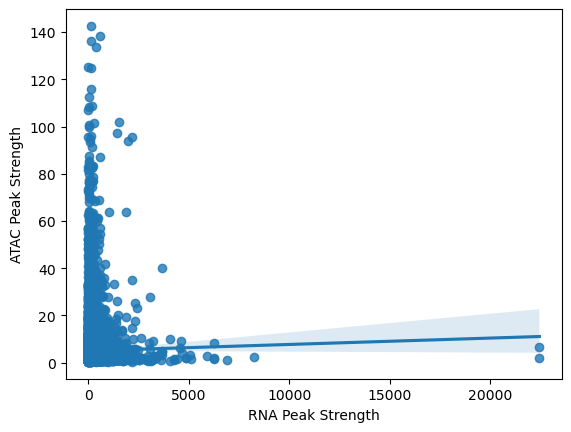

In [87]:
# Ensure "ATAC Peak Strength" is a scalar (mean) for each row
peak_means["ATAC Peak Strength"] = peak_means["ATAC Peak Strength"].apply(
	lambda x: np.mean(x) if isinstance(x, (np.ndarray, list)) else x
)

sns.regplot(data=peak_means.sample(10000), x="RNA Peak Strength", y="ATAC Peak Strength")

    - b. How do the coefficients differ when it is performed on your cell lineage alone?

In [88]:
ilc_columns = ["NK.27+11b-.BM","NK.27+11b+.BM","NK.27-11b+.BM","NK.27+11b-.Sp","NK.27+11b+.Sp","NK.27-11b+.Sp","ILC2.SI", "ILC3.NKp46-CCR6-.SI", "ILC3.NKp46+.SI", "ILC3.CCR6+.SI"]
results_ilc, peak_means_ilc_raw = perform_regression(atac[ilc_columns], rna[ilc_columns])

peak_means_ilc = peak_means_ilc_raw.explode("ATAC Peak Strength")

Computed R² for 17469 genes.


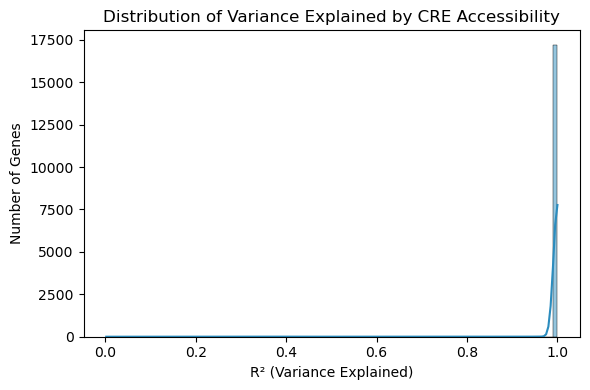

count    17469.000000
mean         0.993551
std          0.062239
min          0.001653
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000


In [89]:

# --- 5. Plot distribution of R² ---
#sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.histplot(results_ilc["R2"], bins=100, kde=True, color="#2b8cbe")
plt.xlabel("R² (Variance Explained)")
plt.ylabel("Number of Genes")
plt.title("Distribution of Variance Explained by CRE Accessibility")
plt.tight_layout()
#plt.savefig("reports/R2_distribution.png", dpi=300)
plt.show()

# Optional: print summary statistics
print(results_ilc["R2"].describe().to_string())

In [90]:
results_ilc.sort_values("R2", ascending=False, inplace=True)
results_ilc.sort_values("n_CRes", ascending=False, inplace=True)
print(f"Top 20 ILC genes by R²:\n{results_ilc.head(20)}")

Top 20 ILC genes by R²:
                R2                                               beta  \
gene                                                                    
Foxp1          1.0  [-0.1662329069246229, -0.006608593012318087, 0...   
Frmd4a         1.0  [0.15097659490562199, 0.1071451199628847, -0.0...   
Sgms1          1.0  [0.02746459352836661, 0.1326085256511964, -0.0...   
Nav2           1.0  [0.25520150592402896, 0.053357162516796564, 0....   
Sept9          1.0  [0.43625852243748575, 0.027115518481845235, 0....   
Arhgef3        1.0  [-0.5198435856998207, 0.6812513687480113, 0.11...   
Rgs3           1.0  [0.513676741841417, 0.774641612018758, 0.09266...   
Dab2ip         1.0  [-0.3265737901550292, 0.21859021001260054, 0.0...   
Filip1l        1.0  [-0.2505400354804306, -0.04101031970127034, 0....   
2010111I01Rik  1.0  [-0.386783848467706, 0.07520319461668157, -0.0...   
Runx1          1.0  [0.0714547792089204, -0.3045042574057774, -0.1...   
Gpr183         1.0  [-0.020

<Axes: xlabel='RNA Peak Strength', ylabel='ATAC Peak Strength'>

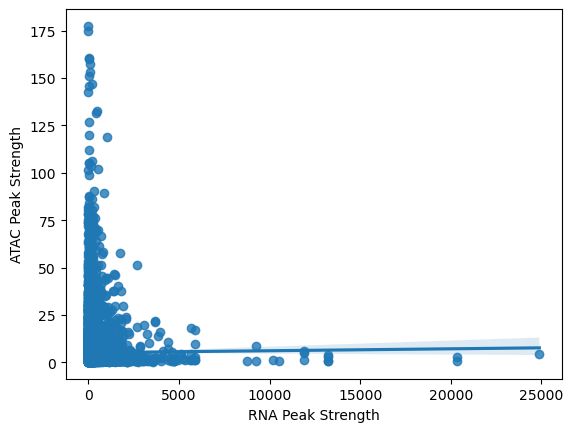

In [91]:
# Ensure "ATAC Peak Strength" is a scalar (mean) for each row
peak_means_ilc["ATAC Peak Strength"] = peak_means_ilc["ATAC Peak Strength"].apply(
	lambda x: np.mean(x) if isinstance(x, (np.ndarray, list)) else x
)

sns.regplot(
	data=peak_means_ilc.sample(10000),
	x="RNA Peak Strength",
	y="ATAC Peak Strength"
)

In [92]:
comp = pd.DataFrame({
    "beta_global": results["beta"],
    "beta_ilc": results_ilc["beta"],
    "beta_diff": results["beta"] - results_ilc["beta"]
})

sns.histplot(comp["beta_diff"].mean(axis=0), bins=2000)
plt.xlim(-20, 20)
plt.title("Distribution of β(Global) − β(ILC)")
plt.xlabel("Coefficient Difference")
plt.show()


ValueError: operands could not be broadcast together with shapes (96,) (46,) 

In [ ]:
# Only keep genes where beta vectors have the same length
mask = comp.apply(
	lambda row: isinstance(row["beta_global"], (list, np.ndarray))
	and isinstance(row["beta_ilc"], (list, np.ndarray))
	and len(row["beta_global"]) == len(row["beta_ilc"]),
	axis=1
)
filtered = comp[mask]

# Compute beta_diff as arrays
beta_diff = filtered.apply(lambda row: np.array(row["beta_global"]) - np.array(row["beta_ilc"]), axis=1)

# Find the most common length among beta_diff arrays
lengths = beta_diff.apply(lambda x: len(x))
common_length = lengths.value_counts().idxmax()

# Filter to only those with the most common length
beta_diff_common = beta_diff[lengths == common_length]

# Compute the mean difference across all genes (per CRE position)
mean_diff = np.mean(np.stack(beta_diff_common.values), axis=0)
mean_diff

array([1.89486442, 1.96976343, 1.86573122, 2.31560253])

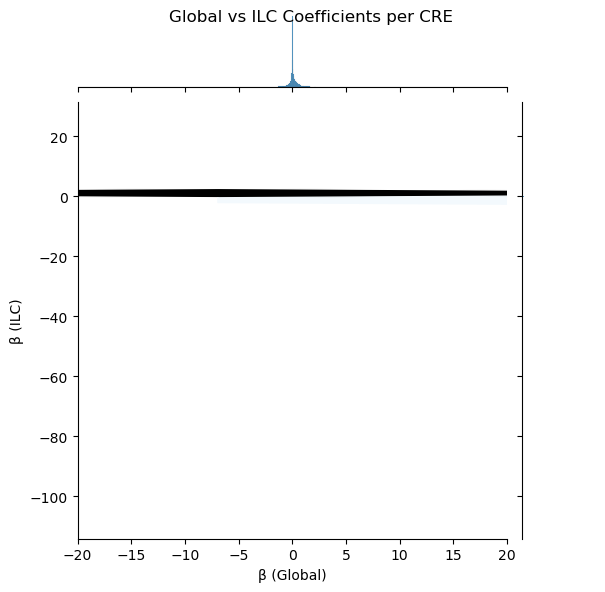

In [ ]:

# 2) Scatter β_global vs β_ilc
sns.jointplot(x="beta_global", y="beta_ilc", data=comp, kind="hex", gridsize=50, xlim=(-20, 20))
plt.xlabel("β (Global)")
plt.ylabel("β (ILC)")
plt.suptitle("Global vs ILC Coefficients per CRE")
plt.show()


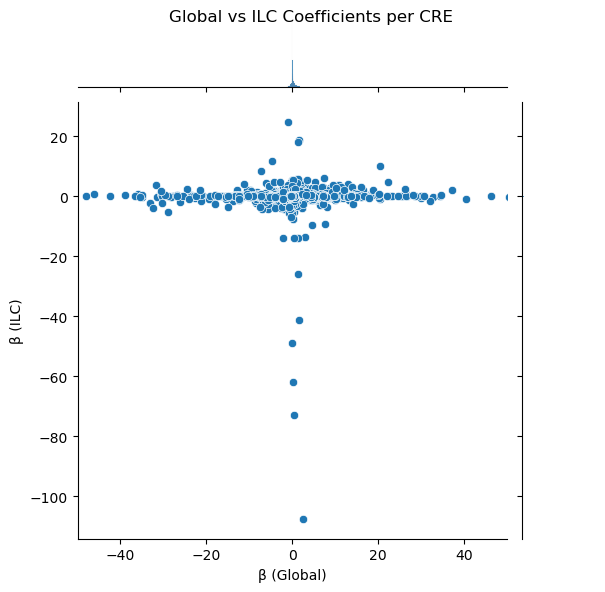

In [ ]:

sns.jointplot(x="beta_global", y="beta_ilc", data=comp, xlim=(-50,50))
plt.xlabel("β (Global)")
plt.ylabel("β (ILC)")
plt.suptitle("Global vs ILC Coefficients per CRE")
plt.show()

In [ ]:
test_data = peak_means_raw.sample(10000)

# Find the most common length of ATAC Peak Strength lists
lengths = test_data["ATAC Peak Strength"].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else np.nan)
common_length = lengths.value_counts().idxmax()

# Filter to only rows with the most common length
filtered = test_data[lengths == common_length]

# Convert the column of lists to a 2D numpy array
X = np.stack(filtered["ATAC Peak Strength"].values)
y = filtered["RNA Peak Strength"].values

model = LinearRegression()
model.fit(X, y)
R2 = model.score(X, y)
print(f"R² for test data: {R2:.4f}")
beta = model.coef_
print(f"β coefficient (mean across features): {np.mean(beta):.4f}")

R² for test data: 0.0538
β coefficient (mean across features): 2.6118


array([-0.21439745,  6.70592771,  2.27165689,  1.68409214])

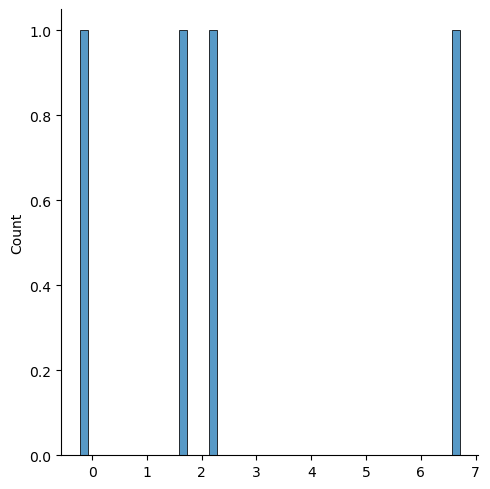

In [ ]:
sns.displot(beta, bins=50)
beta